# Load libraries

In [1]:
import os
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from keras import backend as K

# image processing
from keras.preprocessing import image as image_utils
from keras.preprocessing.image import img_to_array

# pretrained nets
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions

Using TensorFlow backend.


In [3]:
train_image_files_path = "/keras2production/fruits/Training/"
valid_image_files_path = "/keras2production/fruits/Test/"

# Keras

https://keras.io/

## Pretrained nets

https://keras.io/applications/

### Use VGG16

https://keras.io/applications/#usage-examples-for-image-classification-models

In [4]:
model_vgg = VGG16(weights="imagenet")

In [5]:
model_vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [6]:
def classify_image(image):
    img = cv2.imread(image)        
    b,g,r = cv2.split(img)       # get b,g,r
    img = cv2.merge([r,g,b])     # switch it to rgb
    plt.imshow(img)
    plt.xticks([]), plt.yticks([])
    plt.show()
    
    # images need to be numpy arrays of 224 x 224 color images with 3 channels
    image = image_utils.load_img(image, target_size=(224, 224))
    image = image_utils.img_to_array(image)

    # expand the dimensions to be (1, 224, 224, 3)
    image = np.expand_dims(image, axis=0)

    # scale pixels between -1 and 1, sample-wise
    image = preprocess_input(image)
        
    preds = model_vgg.predict(image)
    res = decode_predictions(preds, top=3)
    
    for (i, (imagenetID, label, prob)) in enumerate(res[0]):
        print("{}. {}: {:.2f}%".format(i + 1, label, prob * 100))

In [7]:
train_images = !find $train_image_files_path -type f -name "*.jpg"

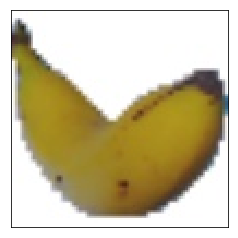

1. banana: 57.43%
2. Granny_Smith: 8.92%
3. lemon: 3.44%


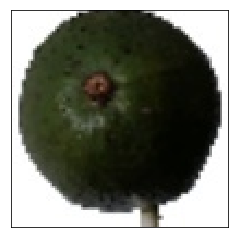

1. acorn: 39.07%
2. gong: 23.67%
3. Granny_Smith: 5.99%


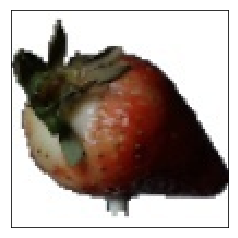

1. hip: 43.99%
2. buckeye: 13.36%
3. strawberry: 12.84%


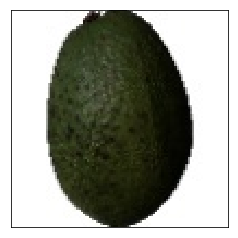

1. tennis_ball: 39.20%
2. gong: 19.76%
3. chime: 11.18%


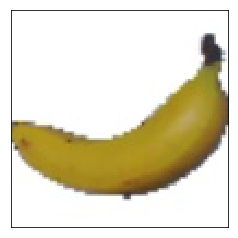

1. banana: 96.54%
2. lemon: 1.98%
3. orange: 0.22%


In [8]:
num = 5
train_images_r = random.sample(train_images, num)
for i in range(num):
    classify_image(train_images_r[i])

# Visualize

In [9]:
image = '/keras2production/notebooks/1-deeplearning/test_images/Banana/Banana_wiki.jpg'
img = image_utils.load_img(image, target_size=(224, 224))
# `x` is a float32 Numpy array of shape (224, 224, 3)
x = image_utils.img_to_array(img)

# We add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)

# Finally we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x)

preds = model_vgg.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n07753592', 'banana', 0.9960743), ('n03532672', 'hook', 0.0008644396), ('n07749582', 'lemon', 0.0007054395)]


In [10]:
banana_output = model_vgg.output[:, np.argmax(preds[0])]
banana_output

<tf.Tensor 'strided_slice:0' shape=(?,) dtype=float32>

In [11]:
# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGGG16
last_conv_layer = model_vgg.get_layer('block5_conv3')

In [12]:
# This is the gradient of the class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(banana_output, last_conv_layer.output)[0]

In [13]:
# This is a vector where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

In [14]:
# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `block5_conv3`,
# given a sample image
iterate = K.function([model_vgg.input], [pooled_grads, last_conv_layer.output[0]])

In [15]:
# These are the values of these two quantities, as Numpy arrays,
# given our sample image 
pooled_grads_value, conv_layer_output_value = iterate([x])

In [16]:
# We multiply each channel in the feature map array
# by "how important this channel is" 
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

In [17]:
# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap.shape

(14, 14)

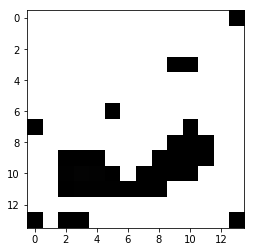

In [18]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.mean(heatmap)
heatmap = np.uint8(heatmap * -0.6)
plt.imshow(heatmap, cmap="Greys")
plt.show()

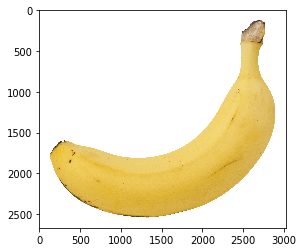

In [19]:
# We use cv2 to load the original image
img = cv2.imread(image)
b,g,r = cv2.split(img)       # get b,g,r
img = cv2.merge([r,g,b])     # switch it to rgb
plt.imshow(img)
plt.show()

In [20]:
# We resize the heatmap to have the same size as the original image
heatmap2 = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

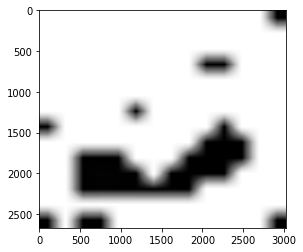

In [21]:
plt.imshow(heatmap2, cmap="Greys")
plt.show()

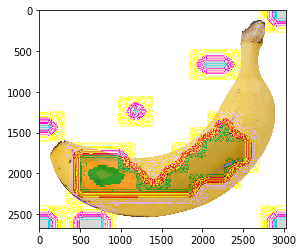

In [22]:
heatmap3 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_HOT)

# 40 here is a heatmap intensity factor
superimposed_img = heatmap3 * 40 + img

plt.imshow(superimposed_img)
plt.show()

In [23]:
out = np.zeros_like(img)

for i in range(out.shape[2]):
    for j in range(out.shape[0]):
        for k in range(out.shape[1]):
            if heatmap2[j,k] == 0:
                out[j,k,i] = 0
            else:
                out[j,k,i] = img[j,k,i]

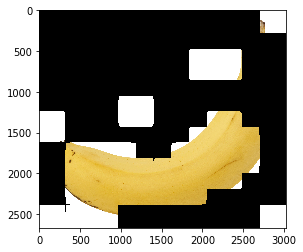

In [24]:
plt.imshow(out)
plt.show()